# Replication

*By Jean-Baptist Astruc, Cesar Denost & Sami Kader-Yettefti*

In this notebook, we replicate the differentially private covariance estimation algorithm presented in [Amin et al., 2019]. Our implementation includes the iterative eigenvalue/eigenvector sampling method as well as baseline approaches such as the Laplace and Gaussian mechanisms. We also reproduce the experiments conducted on the Wine, Adult, and Airfoil datasets from the UCI repository to validate the reported privacy-utility trade-offs.


Running experiments on Wine dataset: X.shape = (13, 178)


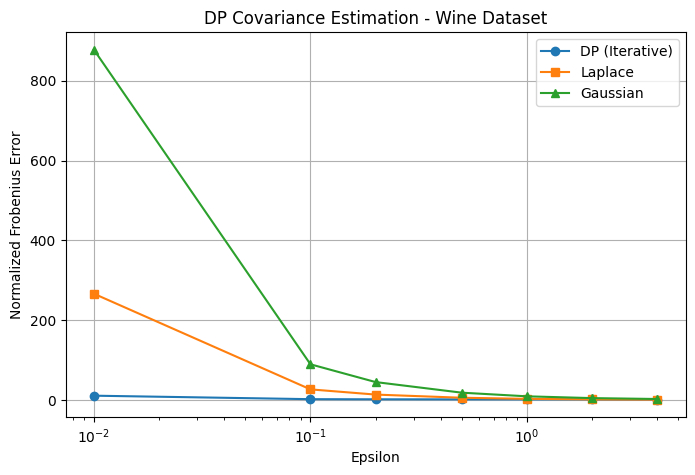

Running experiments on Adult dataset: X.shape = (97, 45222)


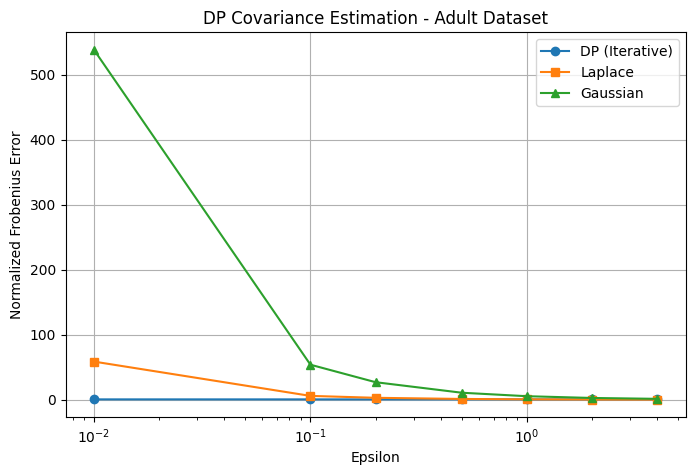

Running experiments on Airfoil dataset: X.shape = (5, 1503)


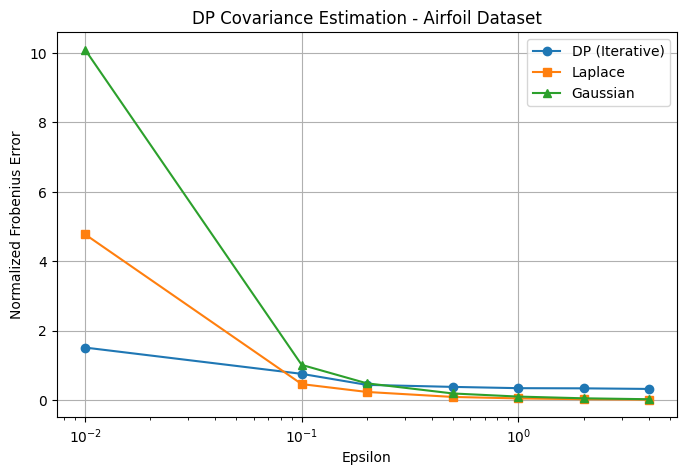

In [3]:
import numpy as np
import pandas as pd
from numpy.linalg import norm, eigh
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine, fetch_openml
from sklearn.preprocessing import StandardScaler

# ===============================
# Utility functions for DP mechanisms
# ===============================

def sample_exponential_mechanism(C, epsilon, num_candidates=500):
    """
    Approximate sampling from the density proportional to exp((epsilon/4)*u^T C u)
    on the unit sphere in R^d.
    
    Parameters:
        C (ndarray): A d x d matrix (typically a projected covariance matrix).
        epsilon (float): Privacy parameter for the current eigenvector estimation.
        num_candidates (int): Number of candidate unit vectors to sample.
    
    Returns:
        u (ndarray): A unit vector sampled approximately from the exponential mechanism.
    """
    d = C.shape[0]
    candidates = np.random.randn(num_candidates, d)
    candidates = candidates / np.linalg.norm(candidates, axis=1, keepdims=True)
    scores = np.array([u.T @ C @ u for u in candidates])
    weights = np.exp((epsilon / 4) * scores)
    weights /= np.sum(weights)
    idx = np.random.choice(num_candidates, p=weights)
    return candidates[idx]

def iterative_eigenvector_sampling(C, eps_total, adaptive=False, delta=0.1, num_candidates=500):
    """
    Implements Algorithm 1: Iterative Eigenvector Sampling for private covariance estimation.
    
    Parameters:
        C (ndarray): True covariance matrix (d x d).
        eps_total (float): Total privacy budget.
        adaptive (bool): If True, use adaptive privacy splitting; otherwise, uniform splitting.
        delta (float): Failure probability for adaptive splitting.
        num_candidates (int): Number of candidate vectors for the exponential mechanism.
    
    Returns:
        C_dp (ndarray): Differentially private estimate of the covariance matrix.
    """
    d = C.shape[0]
    # Use half of the budget for eigenvalue estimation.
    eps0 = eps_total / 2.0
    if not adaptive:
        epsilons = np.full(d, eps_total / (2 * d))
    else:
        # Compute true eigenvalues and add Laplace noise for adaptive splitting.
        eigvals, _ = eigh(C)
        eigvals = np.sort(eigvals)[::-1]  # descending order
        noisy_eigvals = eigvals + np.random.laplace(scale=2/eps0, size=d)
        tau = (2/eps0) * np.log(2 * d / delta)
        sqrt_terms = np.sqrt(np.maximum(noisy_eigvals + tau, 0))
        sum_sqrt = np.sum(sqrt_terms)
        epsilons = (eps_total / 2) * (sqrt_terms / sum_sqrt)
    
    # Initialization
    P = np.eye(d)
    C_current = C.copy()
    theta_list = []
    
    # Also get noisy eigenvalue estimates (for reconstruction)
    eigvals, _ = eigh(C)
    eigvals = np.sort(eigvals)[::-1]
    lambda_hat = eigvals + np.random.laplace(scale=2/eps0, size=d)
    
    for i in range(d):
        u = sample_exponential_mechanism(C_current, epsilons[i], num_candidates=num_candidates)
        theta_i = P @ u
        theta_list.append(theta_i)
        
        # Update projection: get orthonormal basis for complement of span(theta_1,...,theta_i)
        theta_mat = np.array(theta_list).T  # shape: d x (i+1)
        Q_full, _ = np.linalg.qr(theta_mat, mode='complete')
        if i < d - 1:
            P = Q_full[:, i+1:]
            C_current = P.T @ C @ P

    # Reconstruct the DP covariance matrix from eigenvalue and eigenvector estimates.
    C_dp = np.zeros_like(C)
    for i in range(d):
        C_dp += lambda_hat[i] * np.outer(theta_list[i], theta_list[i])
    return C_dp

def dp_covariance_laplace(C, epsilon):
    """
    Differentially private covariance estimation via the Laplace mechanism.
    Adds Laplace noise (scale 2*d/epsilon) to each entry of C.
    """
    d = C.shape[0]
    noise = np.random.laplace(scale=2 * d / epsilon, size=C.shape)
    return C + noise

def dp_covariance_gaussian(C, epsilon, delta):
    """
    Differentially private covariance estimation via the Gaussian mechanism.
    Uses standard deviation proportional to d^(1.5)*sqrt(log(1/delta))/epsilon.
    """
    d = C.shape[0]
    sigma = (d**1.5 * np.sqrt(np.log(1/delta))) / epsilon
    noise = np.random.normal(scale=sigma, size=C.shape)
    return C + noise

# ===============================
# Data loading and preprocessing
# ===============================

def load_wine_dataset():
    """
    Loads the Wine dataset from scikit-learn.
    Returns:
        X: data matrix of shape (d, n) with each column normalized to have ℓ₂ norm at most 1.
    """
    from sklearn.datasets import load_wine
    data = load_wine()
    X = data.data.T  # shape: (d, n)
    # Normalize each column to have norm <= 1
    norms = np.linalg.norm(X, axis=0)
    X = X / np.maximum(norms, 1)
    return X.astype(np.float64)

def load_adult_dataset():
    """
    Loads the Adult dataset from OpenML and performs one-hot encoding on categorical features.
    Returns:
        X: data matrix of shape (d, n) with each column normalized.
    """
    from sklearn.datasets import fetch_openml
    adult = fetch_openml("adult", version=2, as_frame=True)
    df = adult.frame
    # Drop target column and any missing data rows.
    df = df.drop(columns=["class"]).dropna()
    # Separate numerical and categorical features.
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = df.select_dtypes(include=['object', 'category']).columns
    
    # Scale numerical features.
    scaler = StandardScaler()
    df[num_cols] = scaler.fit_transform(df[num_cols])
    
    # One-hot encode categorical features if any exist.
    if len(cat_cols) > 0:
        df_cat = pd.get_dummies(df[cat_cols], drop_first=True)
        df_final = pd.concat([df[num_cols], df_cat], axis=1)
    else:
        df_final = df[num_cols]
    
    # Convert to numpy array, force float type, and transpose so that each column is a data point.
    X = df_final.to_numpy().astype(np.float64).T
    norms = np.linalg.norm(X, axis=0)
    X = X / np.maximum(norms, 1)
    return X

def load_airfoil_dataset():
    """
    Loads the Airfoil Self-Noise dataset from the UCI repository.
    Returns:
        X: data matrix of shape (d, n) with each column normalized.
    """
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat"
    col_names = ["Frequency", "Angle_of_Attack", "Chord_Length", "Free_Stream_Velocity", "Suction_Displacement_Thickness", "Scaled_Sound_Pressure_Level"]
    df = pd.read_csv(url, delim_whitespace=True, header=None, names=col_names)
    # For covariance estimation, use the first 5 features.
    df = df.iloc[:, :5]
    X = df.to_numpy().astype(np.float64).T
    norms = np.linalg.norm(X, axis=0)
    X = X / np.maximum(norms, 1)
    return X

# ===============================
# Experiment Function
# ===============================

def run_experiment_on_dataset(X, epsilon_vals, num_trials=20, method='AD', delta=1e-3):
    """
    Runs experiments on the given dataset X.
    
    Parameters:
        X: data matrix of shape (d, n) where each column is a data point.
        epsilon_vals: list of privacy parameter values.
        num_trials: number of trials for each epsilon.
        method: 'AD' for adaptive or 'IT-U' for uniform privacy splitting.
        delta: delta parameter for the Gaussian mechanism.
    
    Returns:
        errors: dict with keys 'DP', 'Laplace', 'Gaussian' mapping to lists of average normalized Frobenius errors.
    """
    d, n = X.shape
    errors = { 'DP': [], 'Laplace': [], 'Gaussian': [] }
    
    # Compute the true covariance matrix.
    C_true = X @ X.T
    
    for eps in epsilon_vals:
        err_dp = []
        err_lap = []
        err_gauss = []
        for _ in range(num_trials):
            # Apply iterative eigenvector sampling (Algorithm 1).
            if method == 'AD':
                C_dp = iterative_eigenvector_sampling(C_true, eps, adaptive=True, delta=0.1)
            else:
                C_dp = iterative_eigenvector_sampling(C_true, eps, adaptive=False)
            # Laplace mechanism.
            C_lap = dp_covariance_laplace(C_true, eps)
            # Gaussian mechanism.
            C_gauss = dp_covariance_gaussian(C_true, eps, delta=delta)
            
            # Normalized Frobenius error.
            err_dp.append(np.linalg.norm(C_dp - C_true, 'fro') / n)
            err_lap.append(np.linalg.norm(C_lap - C_true, 'fro') / n)
            err_gauss.append(np.linalg.norm(C_gauss - C_true, 'fro') / n)
        
        errors['DP'].append(np.mean(err_dp))
        errors['Laplace'].append(np.mean(err_lap))
        errors['Gaussian'].append(np.mean(err_gauss))
    return errors

# ===============================
# Main Experiment and Plotting
# ===============================

if __name__ == '__main__':
    # Privacy parameter values.
    epsilon_vals = [0.01, 0.1, 0.2, 0.5, 1.0, 2.0, 4.0]
    
    # Dictionary to store errors for each dataset.
    datasets = {
        "Wine": load_wine_dataset(),
        "Adult": load_adult_dataset(),
        "Airfoil": load_airfoil_dataset()
    }
    
    results = {}
    for name, X in datasets.items():
        print(f"Running experiments on {name} dataset: X.shape = {X.shape}")
        errors = run_experiment_on_dataset(X, epsilon_vals, num_trials=20, method='AD', delta=1e-3)
        results[name] = errors
        
        # Plot results for current dataset.
        plt.figure(figsize=(8, 5))
        plt.plot(epsilon_vals, errors['DP'], marker='o', label='DP (Iterative)')
        plt.plot(epsilon_vals, errors['Laplace'], marker='s', label='Laplace')
        plt.plot(epsilon_vals, errors['Gaussian'], marker='^', label='Gaussian')
        plt.xlabel('Epsilon')
        plt.ylabel('Normalized Frobenius Error')
        plt.xscale('log')
        plt.title(f'DP Covariance Estimation - {name} Dataset')
        plt.legend()
        plt.grid(True)
        plt.show()
